In [51]:
import warnings
import numpy as np
import pandas as pd
import time
import sys
# local library
import utils

import matplotlib.pyplot as plt

%matplotlib inline

In [324]:
%%time

symbols = utils.get_sap_symbols('sap500')
np.random.shuffle(symbols)
chosen_symbols = symbols
start_date="2013-04-01"
end_date="2016-03-31"
# use Open data
input_data = utils.get_data_list_key(chosen_symbols, start_date, end_date)
target_data = utils.get_data('^GSPC', start_date, end_date)['Open']

train_st = pd.Timestamp("2014-04-01")
train_end = pd.Timestamp("2015-03-31")
test_st = pd.Timestamp("2015-04-01")
test_end = pd.Timestamp("2016-03-31")

train_input = input_data.loc[(input_data.index >= train_st) & (input_data.index <= train_end)]
train_target = target_data.loc[(target_data.index >= train_st) & (target_data.index <= train_end)]
test_input = input_data.loc[(input_data.index >= test_st) & (input_data.index <= test_end)]
test_target = target_data.loc[(target_data.index >= test_st) & (target_data.index <= test_end)]
    
# training
n_stock = len(train_input.values[0])

we cound not fetch data from the following companies
['CFG', 'FTV', 'NWS', 'COTY', 'SYF', 'UA', 'WRK', 'CSRA', 'NEE', 'EVHC', 'PYPL', 'NWSA', 'WLTW', 'NAVI', 'QRVO', 'KHC', 'MNK', 'ALLE', 'HPE']
CPU times: user 8.1 s, sys: 898 ms, total: 9 s
Wall time: 3min 16s


In [415]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras import backend as K
from six.moves import xrange

class MLP(object):
    """MLP to predict indicator values"""
    def __init__(self, config):
        """Build MLP model through config

        config: the following attributes
            device: device to use for computation, e.g. '/gpu:0'
            save_path: directory to save amd load your model
            is_load: the flag if you use the previous model
            n_stock: the number of caompanies for stock data
            n_batch: batch size for SGD
            n_epochs: the number of interation for training
            learning_rate: initial learning rate value
            anneal: the time when annealing starts
            model: model configuration
        """
        self.device = config['device']
        self.save_path = config['save_path']
        self.is_load = config['is_load']
        self.n_input = config['n_input']
        self.n_output = config['n_output']
        self.n_batch = config['batch_size']
        self.n_epoch = config['n_epoch']
        self.lr = config['learning_rate']
        self.anneal = config['anneal']
        self.model_config = config['model']
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        
    def train(self, input_data, target_data):
        """training MLP with Adam Optimizer
        
        Args:
            input_data (DataFrame): .values have the [None, n_stock] stock prices
            target_data (DataFrame): .values have the [None] indicator values
        """
        # to use for prediciton keep input data
        stock_data = input_data.values
        target_data = target_data.values
        self.data = stock_data
        T = len(stock_data)
        print_freq = int(self.n_epoch / 10)
        if print_freq == 0:
            print_freq = 1
        # index for shuffling
        indices = np.arange(T)
        lr = self.lr
        for epoch in xrange(self.n_epoch):
            np.random.shuffle(indices)
            batch_indices = [indices[i: i + self.n_batch] for i in np.arange(0, T - self.n_batch, self.n_batch)]
            for idx in batch_indices:
                batch_input = [stock_data[t] for t in idx]
                batch_target = [target_data[t] for t in idx]
                # select transition from pool
                self.sess.run(self.optim, 
                              feed_dict={self.input_: batch_input,
                                         self.target: batch_target,
                                         self.N: T,
                                         self.learning_rate: lr,
                                         K.learning_phase(): 1})  
            # update learning rate by annealing
            lr = lr * self.anneal / max(self.anneal, epoch)
            
            
            if epoch % print_freq == 0:
                print ("epoch:",  epoch)
                loss = self.sess.run(self.loss, feed_dict={self.input_: stock_data,
                                                           self.target: target_data,
                                                           self.N: T,
                                                          K.learning_phase(): 0})
                print ('loss:', loss)
            
            
        print ("finished training")
        
    def predict(self, input_data, n_monte=10):
        """Predict indicator values

        Args:
            input_data (DataFrame): .values have the [None, n_stock] stock prices
        """    
        # to stabilize we use more than self.n_batch
        index = input_data.index
        data = input_data.values
        n_data = len(data)
        if n_data < self.n_batch:
            n_add = self.n_batch - n_data 
            data = np.concatenate((self.data[-n_add:], data))
        predictions = []
        for i in xrange(n_monte):
            predictions.append(self.sess.run(self.output, feed_dict={self.input_: data, 
                                                            K.learning_phase(): 1})[-n_data:])
        predictions = np.array(predictions)
        mean = np.mean(predictions, axis=0)
        sig = np.sqrt(np.var(predictions, axis=0))
        return pd.DataFrame({"mean": mean, "sigma": sig}, index=index)

    def accuracy(self, input_data, target_data):
        target_value = target_data.values
        prediction = self.predict(input_data).values
        return np.mean((target_value - prediction)**2)

    
    def build_model(self):
        """Build the network and optimizations """
        self.network = self.build_network()
        self.input_ =  tf.placeholder(tf.float32, [None, self.n_input], name='input')
        self.target = tf.placeholder(tf.float32, [None], name='target')
        network_output = self.network(self.input_)
        self.output = tf.reduce_sum(network_output * self.input_, 1)
        scale = 1.0
        tau = 1.0
        self.loss = 0.5 * tf.reduce_mean((self.output - self.target)**2)
        # compute regularizer coefficient
        lamb = []
        lamW= []
        # the number of data
        self.N = tf.placeholder(tf.float32, name='N')
        for i, layer in enumerate(self.model_config):
            if i == 0:
                lamW.append(0.5 * (1 - layer['drop_rate']) / (tau * self.N))
            else:
                lamW.append(0.5 * layer['n_feature'] * (1 - layer['drop_rate']) / (tau * self.N))
            lamb.append(0.5 * scale / (tau * self.N) )
        # add regularizer
        i_W = 0
        i_b = 0
        for layer in self.network.layers:
            if hasattr(layer, 'W'):
                self.loss += lamW[i_W] * tf.reduce_sum(layer.W**2)
                i_W += 1
            if hasattr(layer, 'b'):
                self.loss += lamb[i_b] * tf.reduce_sum(layer.b**2)
                i_b += 1
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss)
        tf.initialize_all_variables().run(session=self.sess)
        # save model
        self.saver = tf.train.Saver()
            
        
    def build_network(self):
        """Build MLP network"""
        model = Sequential()
        model.add(Lambda(lambda x: x,  input_shape=(self.n_input,)))
        for i, conf in enumerate(self.model_config):
            if conf['is_drop']:
                model.add(Dropout(conf['drop_rate']))
            model.add(Dense(conf['n_feature']))
            if conf['is_batch']:
                model.add(BatchNormalization(mode=1, axis=-1))
            if i < len(self.model_config) - 1:
                model.add(PReLU())
        return model
    
    
    def save(self):
        """Save model at self.save_path"""
        save_path = self.saver.save(self.sess, self.save_path)
        print("Model saved in file: %s" % save_path)

    
    def load(self):
        """Load model from self.save_path if possible"""
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False

In [416]:
config = {'n_epoch': 500, 
          'n_input': n_stock, 
          'learning_rate': 1e-3, 
          'device': '/gpu:0',
          'save_path': None,
         'batch_size': 128, 
          'is_full': True,  
          'anneal': 1000,
          'n_output': n_stock,
          'is_load': False,
          'model': [{'is_full': True, 'n_feature': 100, 'is_batch': True, 'is_drop': False, 'ksize': 4, 'drop_rate': 0.2}, 
                    {'is_full': True, 'n_feature': 100, 'is_batch': True, 'is_drop': False, 'ksize': 3, 'drop_rate': 0.2},
                   {'is_full': True, 'n_feature': 100, 'is_batch': True, 'is_drop': False, 'ksize': 3, 'drop_rate': 0.2},
                    {'is_full': True, 'n_feature': 100, 'is_batch': False, 'is_drop': False, 'ksize': 3, 'drop_rate': 0.2},
                   {'is_full': True, 'n_feature': n_stock, 'is_batch': False, 'is_drop':False, 'ksize': 3, 'drop_rate': 0.0}]}

In [417]:
mlp = MLP(config)
mlp.train(train_input, train_target)

/Users/admin/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1665: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_1_model" was not an Input tensor, it was generated by layer lambda_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_1:0
  str(x.name))


epoch: 0
loss: 34256.7
epoch: 50
loss: 696.071
epoch: 100
loss: 447.539
epoch: 150
loss: 346.394
epoch: 200
loss: 278.771
epoch: 250
loss: 256.409
epoch: 300
loss: 301.468
epoch: 350
loss: 254.993
epoch: 400
loss: 290.489
epoch: 450
loss: 223.622
finished training


In [418]:
%%time
prediction = mlp.predict(test_input, 100)[1:]

CPU times: user 2.64 s, sys: 138 ms, total: 2.78 s
Wall time: 1.03 s


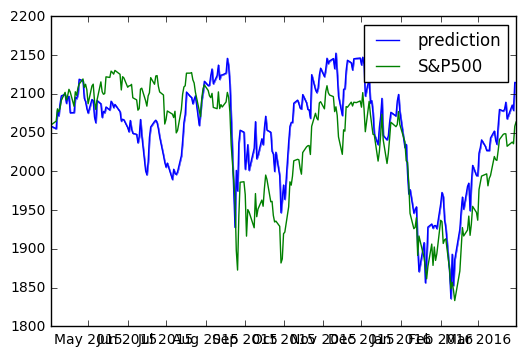

In [419]:
plt.plot(prediction['mean'], label='prediction')
plt.plot(test_target[1:], label='S&P500')
pred_val = prediction.values[:-1]
plt.fill_between(prediction.index, prediction['mean'].values - 2 * prediction['sigma'].values,
                 prediction['mean'].values + 2 * prediction['sigma'].values,
                 alpha=0.5, color='b')
plt.legend()
plt.savefig('dropoutbayes.jpg', dpi=300)

In [420]:
mean = prediction['mean'].values

In [421]:
updown = mean[1:] - mean[:-1] >= 0
target_updown = test_target.values[2:] - test_target.values[1:-1] >= 0

In [422]:
count = 0
for x, y in zip(updown, target_updown):
    if x == y:
        count += 1

In [423]:
float(count) / len(updown)

0.752

In [292]:
False == False

True

In [110]:
model = Sequential()
model.add(Dense(1, input_shape=(10, )))
model.add(Dropout(0.5))
model.add(BatchNormalization(mode=1, axis=-1))
model.add(Dense(2, activation='relu'))

In [111]:
a = model.layers[1]

In [112]:
'dense' in a.name

False

In [113]:
a.W

AttributeError: 'Dropout' object has no attribute 'W'

In [103]:
hasattr(a, 'W')

True

In [204]:
import inspect
inspect.getsourcefile(tf.nn.dropout)

'/Users/admin/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py'